In [1]:
import os
from astropy.io import ascii
import math
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
from astropy.modeling import models, fitting
from astropy import units as u


## List any necessary constants here

In [2]:
CODE_AS = -2
CODE_GS = -1
PRIMARY = 1
FLDCEN_X = 0
FLDCEN_Y = 270
FLIP = -1
YMSKMIN = 187.3
YMSKMAX = 479.1
XUPP_LIM = 498
XLOW_LIM = -498
YCAMCEN = 700
RADVIGN = 302
GAP1CEN =        -254.4          # CCD gap in arcsec -- center
GAP1HWD =           5.2          # CCD gap in arcsec -- half-wid
GAP2CEN =           0.0          # CCD gap in arcsec -- center
GAP2HWD =           5.2          # CCD gap in arcsec -- half-wid
GAP3CEN =         254.4          # CCD gap in arcsec -- center
GAP3HWD =           5.2          # CCD gap in arcsec -- half-wid
M_RCURV = 2120.9
R_IMSURF = 2133.6
M_ANGLE = 6.0
ZPT_YM = 128.803 # Dist to tel.axis, in SMCS-XXX (mm) 5.071in
MASK_HT0 = 3.378
PPLDIST  = 20018.4
FL_TEL  =150327.0


In [3]:
# Auxiliary functions to deal with angles

def degtorad(angle):
    return float(angle*np.pi/180)
def radtodeg(radians):
    return float(radians*57.295779513082320877)
def hhmmsstodegrees(hours):
    return Angle(str(hours)+' hours').degree
def ddmmsstodegrees(dms):
    return Angle(str(dms)+ ' degrees').degree
def degreestohhmmss(degrees):
    return Angle(str(degrees)+' degrees').to_string(unit=u.hour,sep=":")
def degreestoddmmss(degrees):
    return Angle(str(degrees)+' degrees').to_string(unit=u.degree, sep=":")

In [4]:
# Replaces some of the calls to "epar dsimulator"
# the center of the mask is read from the variable "CenterLine"

def InputDataInit():
    InputData={}
    InputData['DEF_BOXR']=0.5*4 # arcseconds for alignment boxes
    InputData['DEF_SLWID']=1 # default slit width arcseconds
    InputData['DEF_HLEN']=5 # minimum slit length
    InputData['RA0_FLD']=degtorad(hhmmsstodegrees(CenterLine.split()[1]))
    InputData['DEC0_FLD']=degtorad(ddmmsstodegrees(CenterLine.split()[2]))
    InputData['HA_FLD']=degtorad(ha0*15)
    InputData['PA_ROT']=degtorad(PA0)
    InputData['TEMP']=0
    InputData['PRES']=600
    InputData['WAVER']=7000*1e-4
    InputData['WAVEMN']=blue*1e-4
    InputData['WAVEMX']=red*1e-4
    InputData['SLIT_GAP'] = sep_slit
    InputData['DEF_HLEN'] = 0.5 * min_slit
    InputData['DEF_SLWID'] = slit_width
    InputData['STD_EQX'] = equinox
    InputData['RA_FLD']=InputData['RA0_FLD'] # no refraction
    InputData['DEC_FLD']=InputData['DEC0_FLD']
    InputData['PROJ_LEN']=True
    return InputData
    

In [5]:
# Reads the input file with targets, makes some angle transformation, creates the target structure

def TargetInit():
    TargetData=[]
 
    data = ascii.read(ObjectFile, format='no_header', names=['id','ra','dec','equinox','mag','band','priority','nlist','selcode','pangle'])
    for i in range(len(data)):
        Target={}
        Target['INDEX']=i
        Target['IDSTR']=data['id'][i]
        ra0=degtorad(hhmmsstodegrees(data['ra'][i]))
        Target['RA0']=ra0
        dec0=degtorad(ddmmsstodegrees(data['dec'][i]))
        Target['DEC0']=dec0
        Target['RA']=Target['RA0'] # no refraction
        Target['DEC']=Target['DEC0']
        Target['MAG']=data['mag'][i]
        Target['PBAND']=data['band'][i][0]
        l1=InputData['DEF_HLEN']
        l2=InputData['DEF_HLEN']
        selcode=0
        nlist=PRIMARY
        Target['PCODE']=data['priority'][i]
        Target['STD_EQX']=data['equinox'][i]
        if data['priority'][i]==CODE_AS:
                l1 = InputData['DEF_BOXR']
                l2 = InputData['DEF_BOXR']
        Target['PA']=data['pangle'][i]
 
        if Target['PCODE']==CODE_AS:
                print("Star %s is an alignment star" % Target['IDSTR'])
                Target['PA']=''
                Target['SLWID']=2*InputData['DEF_BOXR']
        else:
                Target['SLWID']=InputData['DEF_SLWID']
        Target['SAMPL']=nlist
        Target['SEL']=data['selcode'][i]
        
        Target['LEN1']=l1
        Target['LEN2']=l2
        TargetData.append(Target)
        
    return(TargetData)

## Create example data
The data is obtained by connecting to the UCO/LICK database and retrieving the tabular information for one of the masks.
The input coordinates are not in the exact same format that a user would input, but they can be retrieved

In [23]:
ObjectFile = 'example/objects_selected_standard_format'
CenterLine = 'n2419c   17:33:19.5  68:01:12  2000.0 PA=180.000 ##'
ObjectFile = 'n2419c.selected'
CenterLine = 'n2419c             7:38:09.20   38:51:12.0  2000.0 PA=50.000 ##'
ha0 = 0
PA0 = 180 # this is for the file called objects_selected_standard_format
PA0 = 50
blue = 4000
red = 9000
sep_slit = 2
min_slit = 25
slit_width = 1
equinox = 2000
# read some example downloaded from the slitmask database
objects = ascii.read('example/objects')
slitobjmap = ascii.read('example/slitobjmap')
desislit = ascii.read('example/desislit')
bluslits = ascii.read('example/bluslits')
# convert example input objects into standard format
ra = [degreestohhmmss(x['RA_OBJ']) for x in objects]
dec = [degreestoddmmss(x['DEC_OBJ']) for x in objects]
pa=0
priority=[]
for i in range(len(objects)):
    if objects[i]['ObjClass']=='Alignment_Star':
        priority.append(-2)
    else:
        priority.append(100)
 

#the file retrieved from the database is written back to disk in the expected input format that a user might provide

fd = open('example/objects_selected_standard_format','w')
for i in range(len(objects)):
    object = objects[i]
    fd.write("%s %s %s %f %f I %d 1 1 %f\n" % (object['ObjectId'],ra[i],dec[i],object['EQUINOX'],object['mag'],priority[i], pa))
    
fd.close()   

## Read input targets and input data

In [24]:
# read input data
InputData = InputDataInit()
# read targets
TargetData = TargetInit()

Star N2419-D17 is an alignment star
Star N2419-S130 is an alignment star
Star N2419-S147 is an alignment star
Star N2419-S1601 is an alignment star
Star N2419-S1778 is an alignment star
Star N2419-S345 is an alignment star


## Calculate position with reference to telescope axis (field center)

In [25]:
def fld2telax(InputData):
    # this is taken from dsim.x, procedure fld2telax
    # FLD2TELAX:  from field center and rotator PA, calc coords of telescope axis    
    # FLDCEN_X = 0
    # FLDCEN_Y = 0
    r = degtorad(np.sqrt(FLDCEN_X*FLDCEN_X+FLDCEN_Y*FLDCEN_Y)/3600)
    pa_fld = np.arctan2(FLDCEN_Y,FLDCEN_X)
    cosr = np.cos(r)
    sinr = np.sin(r)
    #
    cosd = np.cos(InputData['DEC_FLD']) # this is the declination of the center of the field
    sind = np.sin(InputData['DEC_FLD']) # same
    # pa_fld
    cost = np.cos(InputData['PA_ROT']-pa_fld) # pa_fld is calculated above as arctan(Fldcen_y/fldcen_x)
    sint = np.sin(InputData['PA_ROT']-pa_fld)
    sina = sinr*sint/cosd
    cosa = np.sqrt(1-sina**2)
    InputData['RA_TEL']=InputData['RA_FLD']-np.arcsin(sina)
    InputData['DEC_TEL']=np.arcsin((sind*cosd*cosa-cosr*sinr*cost)/(cosr*cosd*cosa-sinr*sind*cost))
    return InputData

In [26]:
# input data before the transformation looks like this:
print("Before:\n"+str(InputData))
InputData = fld2telax(InputData)
print("After:\n"+str(InputData))

Before:
{'DEF_BOXR': 2.0, 'DEF_SLWID': 1, 'DEF_HLEN': 12.5, 'RA0_FLD': 1.999071036413438, 'DEC0_FLD': 0.6781185920415301, 'HA_FLD': 0.0, 'PA_ROT': 0.8726646259971648, 'TEMP': 0, 'PRES': 600, 'WAVER': 0.7000000000000001, 'WAVEMN': 0.4, 'WAVEMX': 0.9, 'SLIT_GAP': 2, 'STD_EQX': 2000, 'RA_FLD': 1.999071036413438, 'DEC_FLD': 0.6781185920415301, 'PROJ_LEN': True}
After:
{'DEF_BOXR': 2.0, 'DEF_SLWID': 1, 'DEF_HLEN': 12.5, 'RA0_FLD': 1.999071036413438, 'DEC0_FLD': 0.6781185920415301, 'HA_FLD': 0.0, 'PA_ROT': 0.8726646259971648, 'TEMP': 0, 'PRES': 600, 'WAVER': 0.7000000000000001, 'WAVEMN': 0.4, 'WAVEMX': 0.9, 'SLIT_GAP': 2, 'STD_EQX': 2000, 'RA_FLD': 1.999071036413438, 'DEC_FLD': 0.6781185920415301, 'PROJ_LEN': True, 'RA_TEL': 2.000151488712942, 'DEC_TEL': 0.6771161271261953}


The result is to add two fields, RA_TEL and DEC_TEL

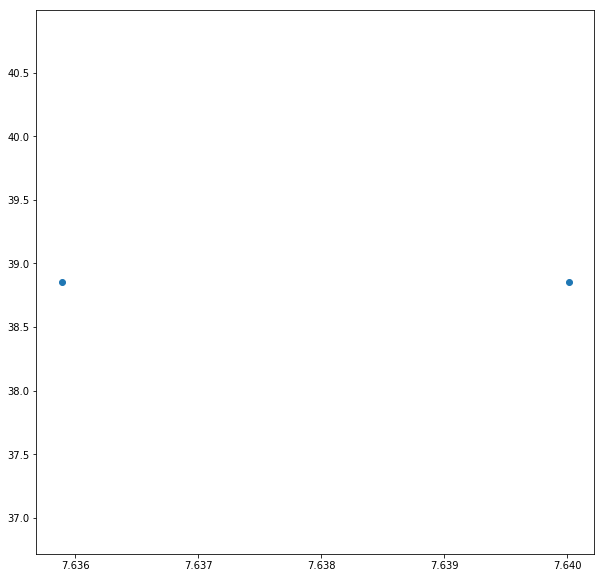

In [27]:
plt.figure(figsize=(10,10))
x=[radtodeg(InputData['RA_FLD'])/15,radtodeg(InputData['RA_TEL'])/15]
y=[radtodeg(InputData['DEC_FLD']),radtodeg(InputData['DEC_FLD'])]
plt.plot(x,y,"o")
plt.show()

## Calculate position of targets with reference to telescope axis (Targets)

In [28]:
def tel_coords(InputData, TargetData):
    # this procedure comes from dsim2.x
    #
    # TEL_COORDS: Convert (refracted) alpha,dec into offsets from telescope center.
    #
    ra0 = InputData['RA_TEL']
    dec0 = InputData['DEC_TEL']
    pa0 = InputData['PA_ROT']
    for i in range(len(TargetData)):
        target = TargetData[i]   # I do this to avoid the notation TargetData[i]
        try:
            dec_obj = target['DEC']
        except:
            print("Target is missing some values")
            print(target)
            return
        del_ra = target['RA']-ra0
        cosr = np.sin(dec_obj) * np.sin(dec0) + np.cos(dec_obj) * np.cos(dec0) * np.cos(del_ra)
        r = np.arccos(cosr)
        
        sinp = np.cos(dec_obj) * np.sin(del_ra) / np.sqrt(1-cosr*cosr)
        cosp = np.sqrt(max((1. - sinp*sinp),0))
        if (dec_obj < dec0):
                cosp = cosp * -1
        p = np.arctan2(sinp, cosp)
        # For now, convert radii to arcsec XXX
        # XXX NB: I am not sure this is correct!  We should still be on SPHERICAL surf.
        # 	but these are EUCLIDEAN relations.  Options: work in spherical coord
        #	OR work in tan projection.
        # More:  The difference at 10 arcmin between the tan and angle is < 0.002 arcsec
        # If we convert "r" to tan(r) we should have the tan projection       
        r = np.tan(r)*206264.8

        target['XARCS'] = r * np.cos(pa0-p)
        target['YARCS'] = r * np.sin(pa0-p)
        
        if target['PA'] == '':
                target['RELPA'] = ''
                rangle=0
        else:
            target['RELPA'] = target['PA']-pa0
            rangle = target['RELPA']
        # For simplicity, we calculate the endpoints in X here; note use of FLIP   
        xgeom = FLIP * np.cos(rangle)
        ygeom = np.sin(rangle)
        
        if InputData['PROJ_LEN'] is True:
            xgeom = xgeom / np.abs(np.cos(rangle))
            ygeom = ygeom / np.abs(np.cos(rangle))
        # We always want X1 < X2, so:    
        if xgeom > 0:
            target['X1'] = target['XARCS']-target['LEN1']* xgeom
            target['Y1'] = target['YARCS']-target['LEN1']* ygeom
            target['X2'] = target['XARCS']+target['LEN2']* xgeom
            target['Y2'] = target['YARCS']+target['LEN2']* ygeom
        else:
            target['X2'] = target['XARCS']-target['LEN1']* xgeom
            target['Y2'] = target['YARCS']-target['LEN1']* ygeom
            target['X1'] = target['XARCS']+target['LEN2']* xgeom
            target['Y1'] = target['YARCS']+target['LEN2']* ygeom
            
        x=target['XARCS']
        y=target['YARCS']
        #print(x,y)
        target['STAT'] = chk_stat(x,y)
        TargetData[i]=target
    return TargetData
        
def chk_stat(x,y):
    r = np.sqrt(x**2+y**2)
    if r>600:
        #print("case1")
        return False
    if y<YMSKMIN:
        #print("case2")
        return False
    if y>YMSKMAX:
        #print("case3")
        return False
    if x>XUPP_LIM or x<XLOW_LIM:
        #print("case4")
        return False
    if x>-0.98273*y+833.0:
        #print("case5")
        return False
    if (x**2+(y-YCAMCEN)**2 < RADVIGN**2):
        #print("case6")
        return False
    if (np.abs(x-GAP1CEN))< GAP1HWD:
            #print("case7")
            return False
    if (np.abs(x-GAP2CEN))< GAP2HWD:
            #print("case8")
            return False
    if (np.abs(x-GAP3CEN))< GAP3HWD:
            #print("case9")
            return False
        
    return True
    
                
        

In [29]:
# Apply the conversion between sky coordinates and the distance in arcseconds from the telescope axis
TargetData = tel_coords(InputData, TargetData)


In [30]:
# read focal plane info
fp = open('foc_plane.dat')
lines = fp.readlines()
fp.close()
xfocalp,yfocalp,pen=[],[],[]
for  line in lines:
    args=line.split()
    if len(args)<2:
        continue
    if len(args)<3 and len(args)>1:
        xfocalp.append(float(args[0]))
        yfocalp.append(float(args[1]))
        pen.append(-1)
    else:
        xfocalp.append(float(args[0]))
        yfocalp.append(float(args[1]))
        pen.append(int(args[2]))
def draw_focal_plane(ax):
    for i in range(len(xfocalp)):
        # if the pen is 0, then this is the first point of the line
        if pen[i]==0:
            x1=xfocalp[i]
            y1=yfocalp[i]
            continue
        # if the pen is not zero, then connect from the previous point
        if pen[i]!=0:
            x2=xfocalp[i]
            y2=yfocalp[i]
            l=mlines.Line2D([x1,x2],[y1,y2])
            x1=x2
            y1=y2
            ax.add_line(l)

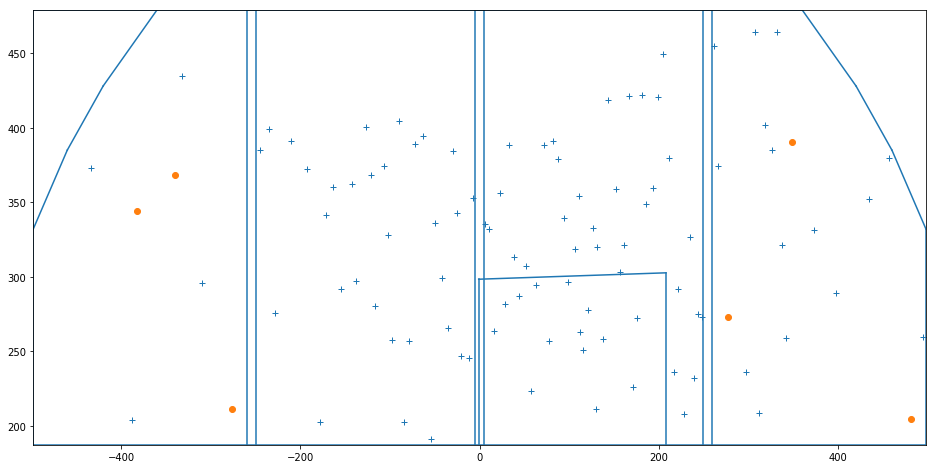

In [31]:
xslit = [x['XARCS'] for x in TargetData if x['PCODE']!=-2]
yslit = [x['YARCS'] for x in TargetData if x['PCODE']!=-2]
xalign = [x['XARCS'] for x in TargetData if x['PCODE']==-2]
yalign = [x['YARCS'] for x in TargetData if x['PCODE']==-2]
xra = [radtodeg(x['RA'])/15 for x in TargetData]
ydec = [radtodeg(x['DEC']) for x in TargetData]
f1,ax1=plt.subplots(1,figsize=(16,8))
ax1.plot(xslit,yslit,'+')
ax1.plot(xalign,yalign,'o')
YMSKMIN = 187.3
YMSKMAX = 479.1
XUPP_LIM = 498
XLOW_LIM = -498
ax1.set_xlim(XLOW_LIM,XUPP_LIM)
ax1.set_ylim(YMSKMIN,YMSKMAX)
draw_focal_plane(ax1)
        
# calculation of limits:
# deimos field of view is 8x16 arcmin = 480 x 960 arcseconds, and it is centered 270 arcseconds away from the telescope axis

#plt.xlim(-400,400)
#plt.ylim(0+270,400+270)

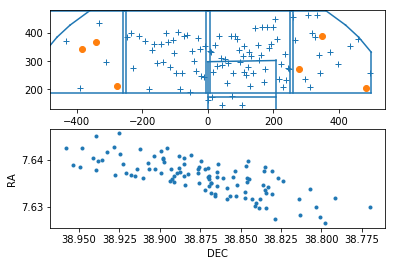

In [32]:
f,(ax1,ax2) = plt.subplots(2)
ax1.plot(xslit,yslit,'+')
ax1.plot(xalign,yalign,'o')
ax2.plot(ydec,xra,'.')
draw_focal_plane(ax1)
(xmin,xmax)=ax2.get_xlim()
ax2.set_xlim(xmax,xmin)
ax2.set_xlabel('DEC')
ax2.set_ylabel('RA')
#ax2.set_xlim(17.568,17.550)
#ax2.set_ylim(68.15,67.85)
#plt.figure(figsize=(16,8))
#plt.plot(xslit,yslit,'+')
#plt.plot(xalign,yalign,'o')
#plt.xlim(-400,400)
#plt.ylim(0,400)
plt.show()

In [33]:
# calculate 2D polynomial
fd = open('input.dat')
lines = fd.readlines()
fd.close()
xin = []
yin = []
for line in lines:
    p = line.split()
    xin.append(float(p[0]))
    yin.append(float(p[1]))

fd = open('output.dat')
lines = fd.readlines()
fd.close()
xout = []
yout = []
for line in lines:
    p = line.split()
    xout.append(float(p[0]))
    yout.append(float(p[1]))

px_init = models.Polynomial2D(degree=4)
fit_px = fitting.LevMarLSQFitter()
px1 = fit_px(px_init,xin,yin,xout)
py_init = models.Polynomial2D(degree=3)
fit_py = fitting.LevMarLSQFitter()
py1 = fit_py(py_init,xin,yin,yout)


In [34]:
print(px1.parameters)
print(py1.parameters)


[ 1.03767274e+00 -2.18808149e-03  7.37670550e-08 -2.01076027e-11
  2.74918216e-15 -3.89696055e-03  2.02511462e-07 -1.62138047e-12
  8.10897848e-15  3.13514189e-07  2.88432985e-08 -3.72487474e-15
 -2.85152369e-10  2.37128749e-13 -2.41487157e-13]
[-1.03918214e+00  1.00220205e+00 -6.72056480e-08 -7.98200666e-12
  3.90475878e-03 -2.15396384e-07 -9.58987366e-13 -3.20708206e-07
 -2.89136300e-08  2.32104252e-10]


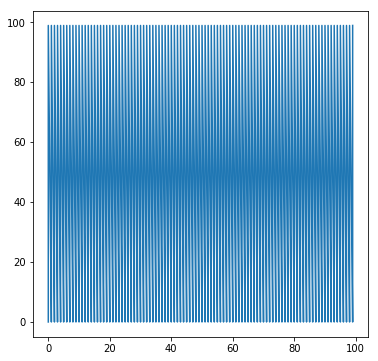

In [35]:
plt.figure(figsize=(6,6))
plt.plot(xin,yin)

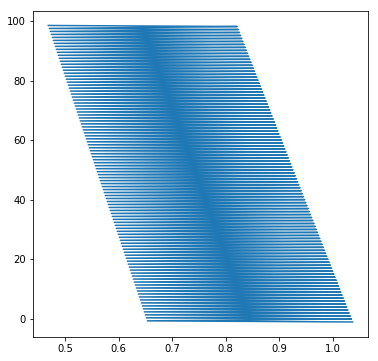

In [36]:
xout_fit = px1(xin,yin)
yout_fit = py1(xin,yin)
plt.figure(figsize=(6,6))
plt.plot(xout_fit,yout_fit)

## Describe the target structure

In [37]:
TargetData[0]

{'INDEX': 0,
 'IDSTR': 'N2419-D17',
 'RA0': 2.0002502972113687,
 'DEC0': 0.6796521546776157,
 'RA': 2.0002502972113687,
 'DEC': 0.6796521546776157,
 'MAG': 17.52,
 'PBAND': 'I',
 'PCODE': -2,
 'STD_EQX': 2000,
 'PA': '',
 'SLWID': 4.0,
 'SAMPL': 1,
 'SEL': 1,
 'LEN1': 2.0,
 'LEN2': 2.0,
 'XARCS': 348.3822083299111,
 'YARCS': 390.5244207026161,
 'RELPA': '',
 'X2': 350.3822083299111,
 'Y2': 390.5244207026161,
 'X1': 346.3822083299111,
 'Y1': 390.5244207026161,
 'STAT': True}

In [48]:
def sel_sort(px1,px2, index, x, pri):
    for i in range(len(px1)-1):
        for j in range(len(px1)-1):
            if px1[j]> px1[j+1]:
                xhold = px1[j+1]
                px1[j+1]=px1[j]
                px1[j]=xhold
                xhold = px2[j+1]
                px2[j+1]=px2[j]
                px2[j]=xhold
    for i in range(len(index)-1):
        for j in range(len(index)-1):
            if x[j]>x[j+1]:
                xhold = x[j+1]
                x[j+1]=x[j]
                x[j]=xhold
                ihold=index[j+1]
                index[j+1]=index[j]
                index[j]=ihold
                phold=pri[j+1]
                pri[j+1]=pri[j]
                pri[j]=phold
                
    return px1, px2, index, x, pri
                
def sel_rank(tdat, indat, tndex, sel, npt, isel, xlow, xupp, minsep, nsel):
    if nsel <=0:
        isel=0
        nsel=0
        
    # can we fit a minimum slit in here?
    if (xupp -xlow < minsep):
        return
    
    # Start at half a slit length; stop inside half slit length
    ndx = tndex[npt]
    x = tdat[ndx]['XARCS']
    xstop = min (x, xupp-0.5*minsep)	# last target or upper limit
    xnext = xlow + 0.5 * minsep
    xlast = xlow
                
    # Loop through to end
    i=isel
    while (i<=npt):
        i=i+1
        ndx = tndex[i]
        x = tdat[ndx]['XARCS']
        if (x < xnext):
            continue
        if (tdat[ndx]['X1'] < xlast):
            continue

        if (x > xstop):
            isel = i - 1
            break

        isel = i
        len = tdat[ndx]['X2'] - tdat[ndx]['X1']
        prisel = tdat[ndx]['PCODE'] / (x - xlast) / len
        # Now look for higher priority to win out, over range (xlast,xlook)
        xlook = min (x+minsep, xstop)
        if (isel < npt):
            for j in range(isel+1, npt):
                ndx = tndex[j]
                if tdat[ndx]['X1'] > tdat[isel]['X2']+indat['SLIT_GAP']:
                    continue # There is no conflict
                # XXX but prisel gets higher?
                if (tdat[ndx]['X2'] > x_upp):
                    continue # XXX Can't use
                xj = tdat[ndx]['XARCS']
                if (xj >= xlook):
                    break
                len = tdat[ndx]['X2'] - tdat[ndx]['X1']
                prinorm = tdat[ndx]['PCODE'] / (xj - xlast) / len
                if (prinorm > prisel):
                    x = xj
                    isel = j
                    prisel = prinorm


        nsel = nsel + 1
        ndx = tndex[isel]
        sel[nsel] = ndx
        xlast = tdat[ndx]['X2']
        xnext = xlast + 0.5 * minsep
        i = isel			# Reset search start point
    return(sel, nsel)

############################################################################
#

#
# SELECTOR: Does an auto selection of slits
# Should include an option for weighting to keep things toward the center.
# Note that y's sent to sel_rank are relative to starting y
# have it run from bottom to top
# -- need to work in segments to accomodate currently selected objects
# -- there was something else ...

def selector(TargetData, InputData, minsep):
    nopt=0
    npre=0
    tdat = TargetData
    sdat = InputData
    for i in range(len(tdat)):
        if tdat[i]['SEL'] == 1:
            npre+=1
        elif tdat[i]['STAT'] == True:
            nopt+=1
            
    bufx1=[]
    bufx2=[]
    bufn=[]
    bufx=[]
    bufp=[]
    bufsel=[]
    
    # Ggrep on previously selected objects and suitable options; fill vectors
    nopt=0
    npre=0
    for i in range(len(tdat)):
        if tdat[i]['PCODE'] == CODE_GS:
            bufx1.append(tdat[i]['X1'])
            bufx2.append(tdat[i]['X2'])
            npre+=1
        elif tdat[i]['STAT'] == True and tdat[i]['PCODE'] > 0:
            bufn.append(i)
            bufx.append(tdat[i]['XARCS'])
            bufp.append(tdat[i]['PCODE'])
            nopt+=1
            
    # Sort the two lists
    print(len(bufx1))
    bufx1, bufx2, bufn, bufx, bufp = sel_sort(bufx1, bufx2, bufn, bufx, bufp)
    
    # the number of gaps to search is npre+1
    ndx=0
    xlow = XLOW_LIM
    xskip = 0.
    nselect =0
    if nopt>0:
        for i in range(npre):
            if i<npre:
                xupp = bufx[i]
                xskip = bufx2[i]-bufx1[i]
            else:
                xupp = XUPP_LIM
                
            if xupp > xlow:
                bufsel, nselect = sel_rank(tdat, sdat, bufn,
                                          bufsel, nopt, i, xlow, xupp, minsep, nselect)
                
            xlow = xupp+xskip
    
    # select the mask slits
    if nselect > 0:
        for i in range(nselect-1):
            tdat[bufsel[i]]['SEL']=1
    psum =0
    for i in range(len(TargetData)):
        if tdat[i]['SEL']:
                    psum = psum + max(tdat[i]['PCODE'], 0)
    return TargetData, psum

In [49]:
TargetData, psum = selector(TargetData, InputData, 2*(InputData['DEF_HLEN']+InputData['SLIT_GAP']))

7


IndexError: list index out of range

In [ ]:
# LEN_SLITS: adjust slit lengths to fit -- perhaps should be integral part of
# gen_slits
# XXX TBD: report conflicts?
#
# from dsim.x
def len_slits(SlitData,InputData):
    sdat=SlitData
    bufx=[]
    bufi=[]
    for i in range(len(SlitData)):
        bufx.append(sdat[i]['XARCS'])
        bufi.append(sdat[i]['INDEX'])
        
    s = sorted(zip(bufx,bufi))
    bufx,bufi = map(list, zip(*s))
    print(len(sdat))
    for i in range(len(sdat)-1):
        ndx1=bufi[i]
        ndx2=bufi[i+1]
        index = ndx1

        pc1=sdat[ndx1]['PCODE']
        pc2=sdat[ndx2]['PCODE']
        
        # if both are alignment boxes, move on...
        if int(pc1)==-2 and int(pc2)==-2:
            continue
            
        xlow = sdat[ndx1]['X2']+InputData['SLIT_GAP']
        xupp = sdat[ndx2]['X1']-InputData['SLIT_GAP']
        xcen = 0.5*(xlow+xupp)
        
        yas = sdat[ndx1]['Y2']
        dxlow = px1(xcen,yas)
        yas = sdat[ndx2]['Y1']
        dxupp = px1(xcen,yas)
        dxavg = 0.5 * (dxupp+dxlow)
        dxlow=dxlow-dxavg
        dxupp=dxupp-dxavg
        #print("%d %d %6.3f %6.3f\n" % (sdat[ndx1]['PCODE'],sdat[ndx2]['PCODE'],dxlow,dxupp))
        if (int(pc1) == -2):
            print("pc1 is Alignment star")
            del1=0
            del2=sdat[ndx2]['X1']-xlow-(dxupp-dxlow)
        elif (int(pc2) == -2):
            print("pc2 is Alignment star")
            del1=xupp-sdat[ndx1]['X2']+(dxlow-dxupp)
            del2=0
        else:
            del1=xcen-0.5*InputData['SLIT_GAP']-sdat[ndx1]['X2']+dxlow
            del2=sdat[ndx2]['X1']-(xcen+0.5*InputData['SLIT_GAP'])-dxupp
        #print(del1,del2)
        oldx2 = sdat[ndx1]['X2']
        sdat[ndx1]['X2']=sdat[ndx1]['X2']+del1
        newx2 = sdat[ndx1]['X2']
        if ndx1==15 or ndx2==15:
            print(index,oldx2,newx2)
        if (del1 !=0 and sdat[ndx1]['RELPA'] != ""):
            tana = np.tan(sdat[ndx1]['RELPA'])
            sdat[ndx1]['Y2']=sdat[ndx1]['Y2']+del1*(-1)*tana
        sdat[ndx2]['X1']=sdat[ndx2]['X1']-del2
        if (del2 !=0 and sdat[ndx2]['RELPA'] != ""):
            tana = np.tan(sdat[ndx2]['RELPA'])
            sdat[ndx2]['Y1']=sdat[ndx2]['Y1']-del2*(-1)*tana
    #print(len(sdat))
    return sdat
 #
# GEN_SLITS: initialize data structure for slits; fill (generate slits)
#  
# from dsim2.x
def gen_slits(TargetData,InputData):
    
    SlitData = []
    # count number of selected targets
    nslit = 0
    for i in range(len(TargetData)):
        if TargetData[0]['SEL']==1:
            nslit+=1
    #print("Number of selected targets: %d out of %d\n" % (nslit,len(TargetData)))
    # sets up the slits
    ndx=0
    for i in range(len(TargetData)):
        slit = {}
        target = TargetData[i]
        if target['PCODE'] == CODE_GS:
            print("%s is a guide star, ignored\n " % target['IDSTR'])
            continue
        if target['SEL'] == 1:
            x = target['XARCS']
            y = target['YARCS']
            #if chk_stat(x,y) == False:
            #    print("Target %s is not on metal, skipping.." % target['IDSTR'])
            #    continue
            slit['INDEX']=ndx
            if target['PA']=='':
                slit['PA']=InputData['PA_ROT']
            else:
                slit['PA']=target['PA']
            slit['RELPA'] = target['RELPA']
            slit['PCODE'] = target['PCODE']
            slit['X1'] = target['X1']
            slit['X2'] = target['X2']
            slit['Y1'] = target['Y1']
            slit['Y2'] = target['Y2']
            
            slit['XARCS'] = target['XARCS']
            slit['YARCS'] = target['YARCS']
            slit['SLWID'] = target['SLWID']
            TargetData[i]['SLNDX'] = ndx
            #print("Adding slit...")
            SlitData.append(slit)
            ndx=ndx+1

    SlitDataNew = len_slits(SlitData,InputData)

    return SlitDataNew,TargetData
        

## Generate slits and extend them to the maximum size

In [ ]:
#print(len(TargetData))
SlitData,TargetData=gen_slits(TargetData,InputData)


## Diagnostic plot of the generated slits

In [ ]:
# we want to plot the centers of the slits SlitData['XARCS'],SlitData['YARCS']
# and lines connecting the extreme points SlitData['X1'],SlitData[Y1] and so on
# generate array of x and y for the plot

xcenter = [x['XARCS'] for x in SlitData if x['PCODE']!=-2]
ycenter = [x['YARCS'] for x in SlitData if x['PCODE']!=-2]
xcenter_align = [x['XARCS'] for x in SlitData if x['PCODE']==-2]
ycenter_align = [x['YARCS'] for x in SlitData if x['PCODE']==-2]
fig,ax = plt.subplots(1,figsize=(16,8))
ax.plot(xcenter,ycenter,'+')
ax.plot(xcenter_align,ycenter_align,'o')
ax.set_xlim(XLOW_LIM,XUPP_LIM)
ax.set_ylim(YMSKMIN,YMSKMAX)
draw_focal_plane(ax)
for slit in SlitData:
    
    l = mlines.Line2D([slit['X1'],slit['X2']],[slit['Y1'],slit['Y2']])
    ax.add_line(l)

In [ ]:
#
# SKY_COORDS: Convert xarcs,yarcs in tel coords onto sky
#   Note that this routine, called infrequently, does not need to be efficient.
#
def sky_coords(SlitData, InputData):
    indat = InputData
    sdat = SlitData
    ra0=indat['RA_TEL']
    dec0 = indat['DEC_TEL']
    pa0 = indat['PA_ROT']
    
    for i in range(len(sdat)):
        x=0.5*(sdat[i]['X1']+sdat[i]['X2'])
        y=0.5*(sdat[i]['Y1']+sdat[i]['Y2'])
        
        r = np.sqrt(x**2+y**2)
        r = np.arctan(r/206264.8)
        phi = pa0-np.arctan2(y,x)
        sind = np.sin(dec0)*np.cos(r)+np.cos(dec0)*np.sin(r)*np.cos(phi)
        sina = np.sin(r)*np.sin(phi)/np.sqrt(1-sind**2)
        sdat[i]['DEC']=np.arcsin(sind)
        sdat[i]['RA']=ra0+np.arcsin(sina)
        
        sdat[i]['XARCS'] = 0.5*(sdat[i]['X1']+sdat[i]['X2'])
        sdat[i]['YARCS'] = 0.5*(sdat[i]['Y1']+sdat[i]['Y2'])
        
        x = sdat[i]['X2']-sdat[i]['X1']
        y = sdat[i]['Y2']-sdat[i]['Y1']
        sdat[i]['LEN1']=0.5*np.sqrt(x**2+y**2)
        sdat[i]['LEN2']=sdat[i]['LEN1']
    return sdat

In [ ]:
SlitData = sky_coords(SlitData,InputData)


In [ ]:
SlitData = tel_coords(InputData,SlitData)

In [ ]:
def gnom_to_dproj(xg,yg):
    DIST_C0 = 0
    DIST_C2 = -1.111311e-8
    rho = np.sqrt(xg**2+yg**2)
    cosa=yg/rho
    sina=xg/rho
    rho = rho * (1.+DIST_C0+DIST_C2*rho**2)
    xd = rho*sina
    yd = rho*cosa
    return xd,yd
   
def proj_to_mask(xp,yp,ap):
    #return xp,yp,ap
    mu = np.arcsin(xp/M_RCURV)
    cosm = np.cos(mu)
    cost = np.cos(degtorad(M_ANGLE))
    tant = np.tan(degtorad(M_ANGLE))
    xx = M_RCURV * mu
    yy = (yp-ZPT_YM)/cost + M_RCURV*tant*(1-cosm)
    
    tanpa = np.tan(degtorad(ap))*cosm/cost+tant*xp/M_RCURV
    ac = radtodeg(np.arctan(tanpa))
    
    #spherical image surface height
    rho = np.sqrt(xp*xp+yp*yp)
    hs = R_IMSURF*(1-np.sqrt(1-(rho/R_IMSURF)**2))
    # mask surface height
    hm = MASK_HT0 + yy * np.sin(degtorad(M_ANGLE))+M_RCURV*(1-cosm)
    #correction
    yc = yy + (hs - hm) * yp / PPLDIST / cost
    xc = xx + (hs - hm) * xp / PPLDIST / cosm
    return xc,yc,ac


    

In [ ]:
def mask_coords(SlitData):
    asec_rad = 206264.8
    
    # offset from telescope axis to slitmask origin, in slitmask coordinates
    yoff = ZPT_YM*(1-np.cos(degtorad(M_ANGLE)))
    yoff = 0 #### CHECK!
    xoff = 0
    for i in range(len(SlitData)):
        sdat = SlitData[i]
        if sdat['RELPA']!="":
            cosa = np.cos(sdat['RELPA'])
            sina = np.sin(sdat['RELPA'])
        else:
            cosa=1
            sina=0

        # recalculation, probably not needed
        sdat['X1']=sdat['XARCS']-sdat['LEN1']*cosa*(-1)
        sdat['Y1']=sdat['YARCS']-sdat['LEN1']*sina
        sdat['X2']=sdat['XARCS']+sdat['LEN2']*cosa*(-1)
        sdat['Y2']=sdat['YARCS']+sdat['LEN2']*sina
    
        # x1,y1 are now tan projections
        
        xfp = FL_TEL*sdat['X1']/asec_rad
        yfp = FL_TEL*(sdat['Y1']-0.5*sdat['SLWID'])/asec_rad
        pa = 0
        xfp,yfp = gnom_to_dproj(xfp,yfp)
        xsm,ysm,pa = proj_to_mask(xfp,yfp,pa)
        sdat['XMM1']=xsm+xoff
        sdat['YMM1']=ysm+yoff
    
        xfp = FL_TEL*sdat['X2']/asec_rad
        yfp = FL_TEL*(sdat['Y2']-0.5*sdat['SLWID'])/asec_rad
        pa = 0
        xfp,yfp = gnom_to_dproj(xfp,yfp)
        xsm,ysm,pa = proj_to_mask(xfp,yfp,pa)
        sdat['XMM2']=xsm+xoff
        sdat['YMM2']=ysm+yoff
    
        xfp = FL_TEL*sdat['X2']/asec_rad
        yfp = FL_TEL*(sdat['Y2']+0.5*sdat['SLWID'])/asec_rad
        pa = 0
        xfp,yfp = gnom_to_dproj(xfp,yfp)
        xsm,ysm,pa = proj_to_mask(xfp,yfp,pa)
        sdat['XMM3']=xsm+xoff
        sdat['YMM3']=ysm+yoff
 
        xfp = FL_TEL*sdat['X1']/asec_rad
        yfp = FL_TEL*(sdat['Y1']+0.5*sdat['SLWID'])/asec_rad
        pa = 0
        xfp,yfp = gnom_to_dproj(xfp,yfp)
        xsm,ysm,pa = proj_to_mask(xfp,yfp,pa)
        sdat['XMM4']=xsm+xoff
        sdat['YMM4']=ysm+yoff
    
        # here we should call metal check
        SlitData[i]=sdat
        
    return SlitData
    


In [ ]:
SlitData=mask_coords(SlitData)

In [ ]:
# plot
factor=1

fig1,ax2 = plt.subplots(1,figsize=(16,6.5))
minx = min([x['XMM1'] for x in SlitData])
maxx = max([x['XMM1'] for x in SlitData])
miny = min([x['YMM1']*factor for x in SlitData])
maxy = max([x['YMM1']*factor for x in SlitData])
print(miny,maxy)
ax2.set_xlim(-400,400)
ax2.set_ylim(0,250)
#ax2.set_ylim(miny,maxy+50)
for slit in SlitData:
    x = [slit['XMM1'],slit['XMM2'],slit['XMM3'],slit['XMM4'],slit['XMM1']]
    y = [slit['YMM1'],slit['YMM2'],slit['YMM3'],slit['YMM4'],slit['YMM1']]
    l = mlines.Line2D(x,y)
    ax2.add_line(l)

In [ ]:
# plot example
slits = ascii.read('example/bluslits')
fig,ax = plt.subplots(1,figsize=(16,6.5))
ax.set_xlim([-400, 400])
ax.set_ylim([0, 250])
for slit in slits:
    x = [slit['slitX1'],slit['slitX2'],slit['slitX3'],slit['slitX4'],slit['slitX1']]
    y = [slit['slitY1'],slit['slitY2'],slit['slitY3'],slit['slitY4'],slit['slitY1']]
    l = mlines.Line2D(x,y)
    ax.add_line(l)

In [ ]:
SlitData